In [2]:
import sys
import os 
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import gpytorch
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if needed

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from proteinshake.datasets import ProteinLigandInterfaceDataset, ProteinFamilyDataset
from src.utils import data_utils as dtu
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

In [4]:
dataset = ProteinFamilyDataset(root='../data').to_graph(eps = 8).pyg()

Converting: 100%|██████████| 31109/31109 [00:38<00:00, 812.66it/s]


In [39]:
dataset[0][1]['residue'].keys()

dict_keys(['residue_number', 'residue_type', 'x', 'y', 'z', 'SASA', 'RSA'])

In [33]:
protein_fam = []
lengths = []
average_RSA = []
for sample in dataset:
    protein_fam.append(sample[1]['protein']['Pfam'][0])
    lengths.append(len(sample[1]['protein']['sequence']))
    average_RSA.extend(sample[1]['residue']['RSA'])

In [34]:
sum(average_RSA)/ len(average_RSA)

0.31080046090205843

In [17]:
unique_pfam = list(np.unique(np.array(protein_fam)))
num_unique_protein_fam = len(unique_pfam)
unique_pfam_length_dict = {pfam: [] for pfam in unique_pfam}
unique_pfam_length_dict_counts = {pfam: 0 for pfam in unique_pfam}

for sample in dataset:
    pfam = sample[1]['protein']['Pfam'][0]
    length = len(sample[1]['protein']['sequence'])
    unique_pfam_length_dict[pfam].append(length)
    unique_pfam_length_dict_counts[pfam] += 1

In [26]:
sum(lengths)/ len(lengths)

251.2693111318268

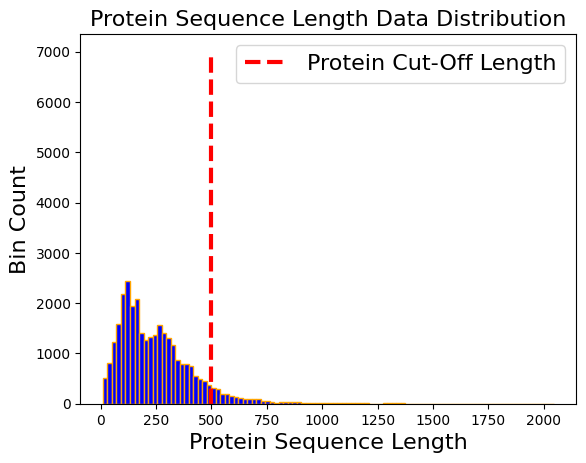

In [49]:
plt.hist(lengths, bins=100, color='blue', edgecolor='orange')
plt.ylabel('Bin Count', fontsize = 16)
plt.xlabel('Protein Sequence Length', fontsize = 16)
plt.title('Protein Sequence Length Data Distribution', fontsize = 16)
plt.vlines(x = 500, ymax=7000, ymin=0, colors='r', linestyles='--', label = 'Protein Cut-Off Length', lw = 3)
plt.legend(fontsize = 16)
plt.savefig('Protein_Sequence_Length_Dist.png', dpi = 200)

In [54]:
dataset[0][1]['protein']

{'ID': '2CJZ',
 'sequence': 'NLYFQSSMSRVLQAEELHEKALDPFLLQAEFFEIPMNFVDPKEYDIPGLVRKNRYKTILPNPHSRVCLTSPDPDDPLSSYINANYIRGYGGEEKVYIATQGPIVSTVADFWRMVWQEHTPIIVMITTEYWPEEQVAYDGVEITVQKVIHTEDYRLRLISLKSEERGLKHYWFTSWPDQKTPDRAPPLLHLVREVEEAAQQEGPHCAPIIVHSSAGIGRTGCCFIATSICCQQLRQEGVVDILKTTCQLRQDRGGMIQTCEQYQFVHHVMSLYEKQLS',
 'Pfam': ['PF00102'],
 'random_split': 'train',
 'sequence_split_0.5': 'train',
 'sequence_split_0.6': 'train',
 'sequence_split_0.7': 'train',
 'sequence_split_0.8': 'train',
 'sequence_split_0.9': 'train',
 'structure_split_0.3': 'train',
 'structure_split_0.4': 'train',
 'structure_split_0.5': 'train',
 'structure_split_0.6': 'train',
 'structure_split_0.7': 'train',
 'structure_split_0.8': 'train',
 'structure_split_0.9': 'train'}

In [55]:
dataset[0][1]['protein']
for idx, sample in enumerate(dataset):
    if len(sample[1]['protein']['Pfam']) > 1:
        print(idx)
        print(sample[1]['protein']['Pfam'])

5
['PF14575', 'PF07714']
10
['PF12799', 'PF12354', 'PF13855']
11
['PF00076', 'PF00641']
13
['PF00158', 'PF00072']
16
['PF00483', 'PF14602']
19
['PF00433', 'PF00069']
20
['PF00419', 'PF09160']
29
['PF01433', 'PF17900', 'PF09127']
31
['PF01082', 'PF03712']
32
['PF17384', 'PF02576']
34
['PF00307', 'PF01494']
35
['PF00109', 'PF02801']
39
['PF00622', 'PF13765']
43
['PF08715', 'PF01661']
46
['PF05173', 'PF01113']
51
['PF18395', 'PF18019']
57
['PF01238', 'PF20512', 'PF20511']
68
['PF00672', 'PF13675']
70
['PF17655', 'PF08466', 'PF01007']
72
['PF02779', 'PF02780']
86
['PF17864', 'PF00004', 'PF05491']
87
['PF07726', 'PF17863']
99
['PF00196', 'PF03472']
115
['PF17482', 'PF04984']
118
['PF12105', 'PF00588']
132
['PF03945', 'PF00555', 'PF03944']
137
['PF02868', 'PF01447']
139
['PF17432', 'PF17900', 'PF11940', 'PF01433']
145
['PF12946', 'PF12947']
151
['PF00271', 'PF13588', 'PF04851']
154
['PF17757', 'PF03461', 'PF00271', 'PF00270', 'PF02559']
161
['PF02543', 'PF16861']
164
['PF08240', 'PF00107']
1

In [197]:
unique_pfam_length_dict_counts = dict(sorted(unique_pfam_length_dict_counts.items(), key=lambda item: item[1], reverse=True))

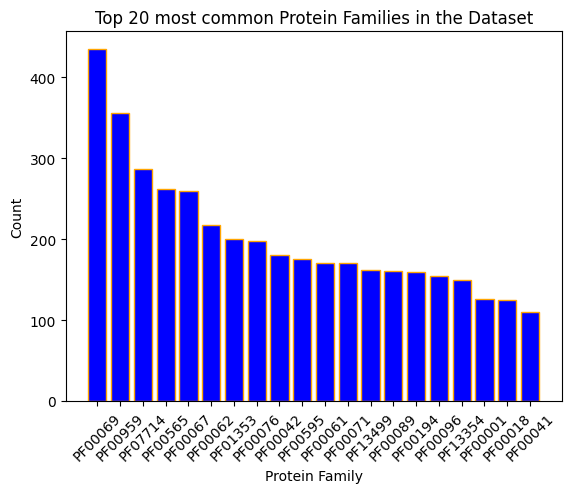

In [198]:
plt.bar(list(unique_pfam_length_dict_counts.keys())[:20], list(unique_pfam_length_dict_counts.values())[:20], color = 'b', edgecolor = 'orange')
plt.xticks(rotation=45)
plt.title('Top 20 most common Protein Families in the Dataset')
plt.ylabel('Count')
plt.xlabel('Protein Family')
plt.show()

In [40]:
unique_pfam_length_dict_gtseq = dict()
unique_pfam_length_dict_gtseq_counts = {pfam: 0 for pfam in unique_pfam}

unique_pfam_length_dict_leseq = dict()
unique_pfam_length_dict_leseq_counts = {pfam: 0 for pfam in unique_pfam}

seq_len = 500
for key in unique_pfam_length_dict.keys():
    fam = unique_pfam_length_dict[key]
    prot_gt_list = []
    prot_ls_list = []
    for prot in fam:
        if prot > seq_len:
            prot_gt_list.append(prot)
            unique_pfam_length_dict_gtseq_counts[key] += 1
        else:
            prot_ls_list.append(prot)
            unique_pfam_length_dict_leseq_counts[key] += 1
    unique_pfam_length_dict_gtseq[key] = prot_gt_list
    unique_pfam_length_dict_leseq[key] = prot_ls_list

In [ ]:
total_num_samples_refined = []

{'PF00001': [443,
  451,
  479,
  26,
  290,
  446,
  442,
  310,
  442,
  438,
  439,
  410,
  28,
  416,
  437,
  32,
  439,
  410,
  47,
  382,
  393,
  444,
  390,
  390,
  32,
  440,
  445,
  478,
  473,
  40,
  461,
  456,
  439,
  340,
  347,
  393,
  33,
  442,
  436,
  367,
  387,
  25,
  328,
  441,
  420,
  388,
  483,
  446,
  416,
  29,
  423,
  12,
  390,
  370,
  370,
  291,
  428,
  375,
  19,
  379,
  391,
  441,
  392,
  397,
  431,
  286,
  18,
  291,
  363,
  398,
  418,
  460,
  445,
  10,
  361,
  385,
  34,
  477,
  348,
  389,
  470,
  383,
  388,
  375,
  312,
  31,
  388,
  485,
  390,
  444,
  382,
  398,
  296,
  423,
  461,
  351,
  64,
  449,
  421,
  330,
  437,
  463,
  418,
  64,
  437,
  25,
  340,
  442,
  429,
  370,
  312,
  309,
  478,
  455,
  471,
  428,
  376,
  381,
  34],
 'PF00002': [416],
 'PF00003': [412, 407],
 'PF00004': [367,
  283,
  263,
  240,
  336,
  368,
  278,
  263,
  364,
  101,
  262,
  270,
  185,
  293,
  269,
  282,
  240,
 

In [241]:
unique_pfam_length_dict_gtseq_counts =  dict(sorted(unique_pfam_length_dict_gtseq_counts.items(), key=lambda item: item[1], reverse=True))

In [243]:
# plt.bar(list(unique_pfam_length_dict_gtseq_counts.keys())[:5000], list(unique_pfam_length_dict_gtseq_counts.values())[:5000], color = 'b', edgecolor = 'orange')
# plt.xticks(rotation=45)
# plt.title('Top 20 most common Protein Families in the Dataset')
# plt.ylabel('Count')
# plt.xlabel('Protein Family')
# plt.figure(figsize=(60, 20))
# plt.show()

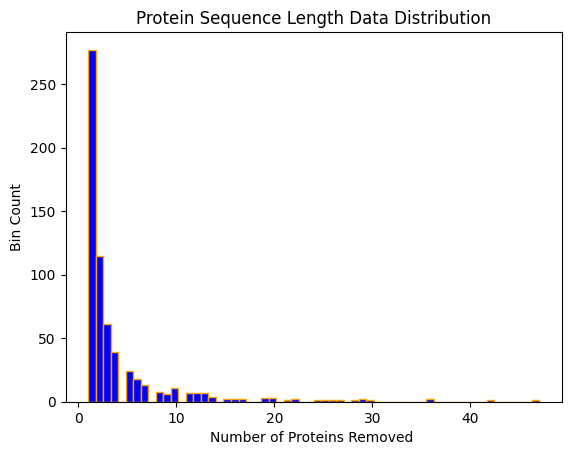

In [244]:
zeros_removed = {k: v for k, v in unique_pfam_length_dict_gtseq_counts.items() if v != 0}
plt.hist(list(zeros_removed.values()), bins=60, color='blue', edgecolor='orange')
plt.ylabel('Bin Count')
plt.xlabel('Number of Proteins Removed ')
plt.title('Protein Sequence Length Data Distribution')
# plt.vlines(x = 500, ymax=5000, ymin=0, colors='r', linestyles='--', label = 'Protein Cut-Off')
plt.savefig('Protein_Sequence_Length_Dist.png', dpi = 200)

In [245]:
class_percentage_removed = {k: v/unique_pfam_length_dict_counts[k] for k, v in unique_pfam_length_dict_gtseq_counts.items() if v != 0}

In [246]:
sum(np.array(list(class_percentage_removed.values())) == 1) / np.array(list(class_percentage_removed.values())).shape[0]

0.46474358974358976

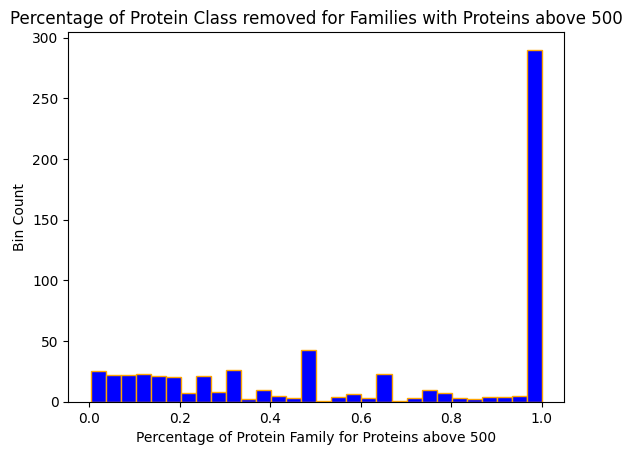

In [251]:

plt.hist(list(class_percentage_removed.values()), bins=30, color='blue', edgecolor='orange')
plt.ylabel('Bin Count')
plt.xlabel(f'Percentage of Protein Family for Proteins above {seq_len}')
plt.title(f'Percentage of Protein Class removed for Families with Proteins above {seq_len}')
# plt.vlines(x = 500, ymax=5000, ymin=0, colors='r', linestyles='--', label = 'Protein Cut-Off')
plt.savefig('Protein_class_percentage_removal.png', dpi = 200)

In [42]:
final_dict_non_zeros = {k: v for k, v in unique_pfam_length_dict_leseq_counts.items() if v != 0}

In [44]:
sum([v for k,v in final_dict_non_zeros.items()])

28751

In [45]:
len(final_dict_non_zeros.keys())

4873

In [48]:
final_lengths = []


for k,v in unique_pfam_length_dict_leseq.items():
    if v != []:
        final_lengths.extend(v)

sum(final_lengths)/len(final_lengths)

216.09046641855934